In [18]:
import pandas as pd 

data=pd.read_csv('../data/raw/sample.csv')
cols=data.columns[1:]
print(data.head(),cols)


   Gesture       T0       T1       T2       T3    Thumb       I3       I2  \
0  courser  436,351  418,341  407,319  411,300  420,290  413,297  414,270   
1  courser  473,267  456,258  442,238  445,217  456,203  443,212  439,184   
2  courser  461,273  444,263  429,243  434,223  449,213  434,212  432,185   
3  courser  402,261  388,258  372,241  371,222  382,211  379,210  375,187   
4  courser  408,270  389,261  373,243  370,225  380,213  379,208  374,180   

        I1    Index  ...       M1   Middle       R3       R2       R1  \
0  416,253  416,239  ...  431,289  430,302  444,302  446,284  446,294   
1  439,167  441,152  ...  459,217  458,230  473,218  474,202  469,223   
2  432,169  434,154  ...  448,219  446,232  463,220  464,207  458,228   
3  372,170  371,157  ...  384,216  384,230  409,213  400,202  395,225   
4  372,164  372,148  ...  383,217  383,231  407,214  400,204  396,227   

      Ring       L3       L2       L1   Little  
0  444,305  458,309  461,292  458,300  456,309  


In [19]:
#preprocessing step

for col in cols:
    data[[col+'_x',col+'_y']]=data[col].str.split(',',expand=True)
    data=data.astype({col+'_x':'float64',col+'_y':'float64'})
    data.drop(columns=[col],inplace=True)
  

In [20]:
import matplotlib.pyplot as plt
print(data.head())
print(cols)


   Gesture   T0_x   T0_y   T1_x   T1_y   T2_x   T2_y   T3_x   T3_y  Thumb_x  \
0  courser  436.0  351.0  418.0  341.0  407.0  319.0  411.0  300.0    420.0   
1  courser  473.0  267.0  456.0  258.0  442.0  238.0  445.0  217.0    456.0   
2  courser  461.0  273.0  444.0  263.0  429.0  243.0  434.0  223.0    449.0   
3  courser  402.0  261.0  388.0  258.0  372.0  241.0  371.0  222.0    382.0   
4  courser  408.0  270.0  389.0  261.0  373.0  243.0  370.0  225.0    380.0   

   ...  Ring_x  Ring_y   L3_x   L3_y   L2_x   L2_y   L1_x   L1_y  Little_x  \
0  ...   444.0   305.0  458.0  309.0  461.0  292.0  458.0  300.0     456.0   
1  ...   467.0   236.0  486.0  224.0  485.0  214.0  480.0  228.0     477.0   
2  ...   455.0   240.0  476.0  228.0  475.0  219.0  468.0  234.0     464.0   
3  ...   394.0   238.0  423.0  221.0  412.0  215.0  406.0  231.0     405.0   
4  ...   396.0   240.0  421.0  221.0  412.0  216.0  407.0  231.0     406.0   

   Little_y  
0     309.0  
1     237.0  
2     243.0  


In [21]:
#normalization
print(data.columns[1:])
x=cols+'_x'
y=cols+'_y'
data[x]=data[x].sub(data[x].min(axis=1), axis=0).div(data[x].max(axis=1) - data[x].min(axis=1), axis=0)
data[y]=data[y].sub(data[y].min(axis=1), axis=0).div(data[y].max(axis=1) - data[y].min(axis=1), axis=0)

print(data.head())

Index(['T0_x', 'T0_y', 'T1_x', 'T1_y', 'T2_x', 'T2_y', 'T3_x', 'T3_y',
       'Thumb_x', 'Thumb_y', 'I3_x', 'I3_y', 'I2_x', 'I2_y', 'I1_x', 'I1_y',
       'Index_x', 'Index_y', 'M3_x', 'M3_y', 'M2_x', 'M2_y', 'M1_x', 'M1_y',
       'Middle_x', 'Middle_y', 'R3_x', 'R3_y', 'R2_x', 'R2_y', 'R1_x', 'R1_y',
       'Ring_x', 'Ring_y', 'L3_x', 'L3_y', 'L2_x', 'L2_y', 'L1_x', 'L1_y',
       'Little_x', 'Little_y'],
      dtype='object')
   Gesture      T0_x  T0_y      T1_x      T1_y      T2_x      T2_y      T3_x  \
0  courser  0.537037   1.0  0.203704  0.910714  0.000000  0.714286  0.074074   
1  courser  0.723404   1.0  0.361702  0.921739  0.063830  0.747826  0.127660   
2  courser  0.680851   1.0  0.319149  0.915966  0.000000  0.747899  0.106383   
3  courser  0.596154   1.0  0.326923  0.971154  0.019231  0.807692  0.000000   
4  courser  0.745098   1.0  0.372549  0.926230  0.058824  0.778689  0.000000   

       T3_y   Thumb_x  ...    Ring_x    Ring_y      L3_x      L3_y      L2_x  \
0  0.5

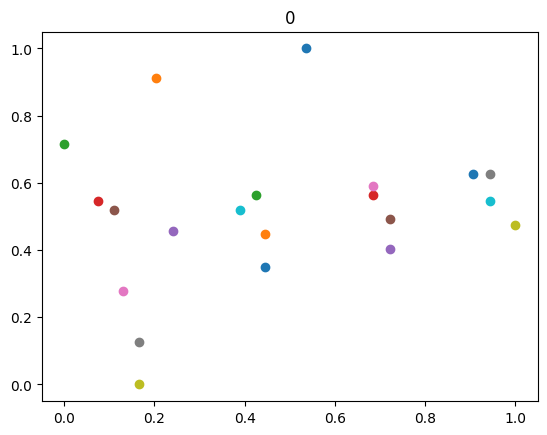

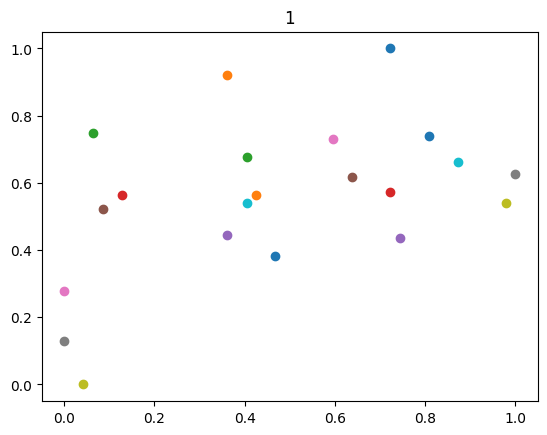

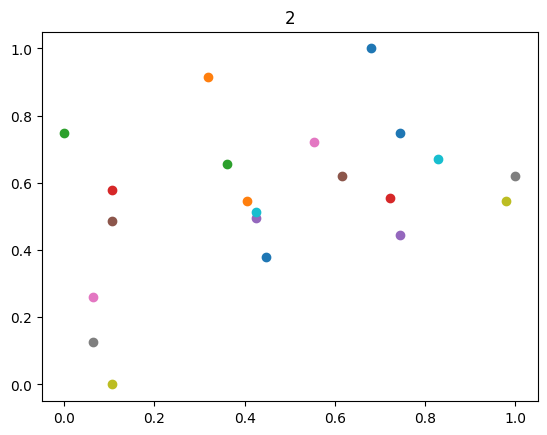

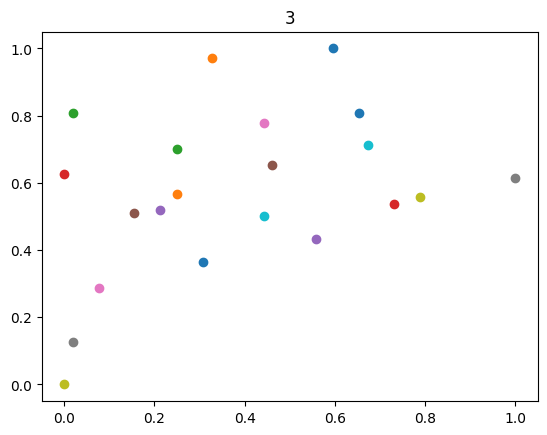

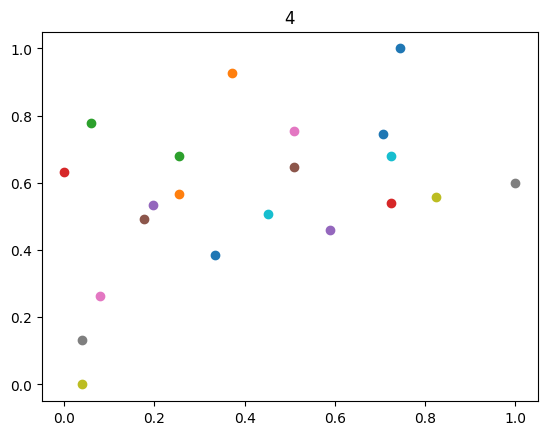

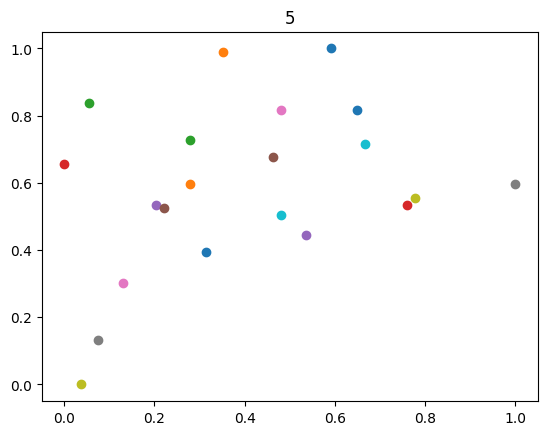

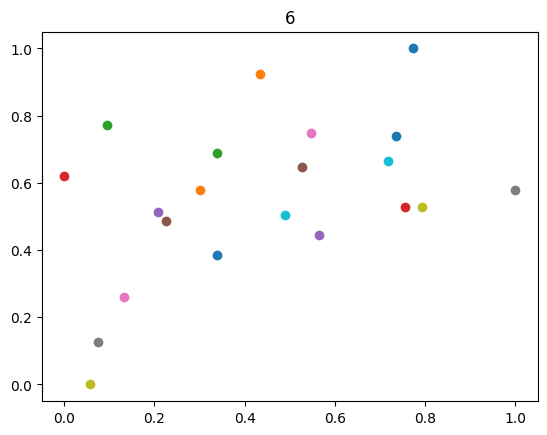

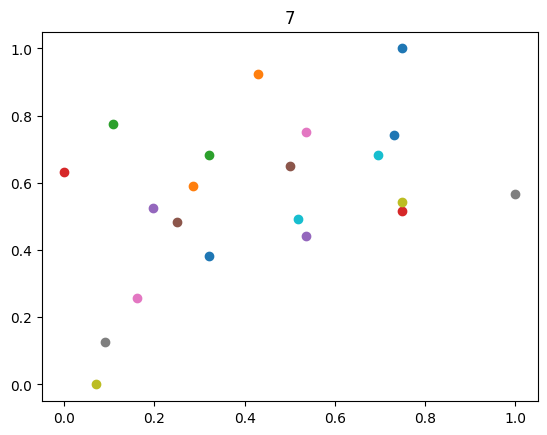

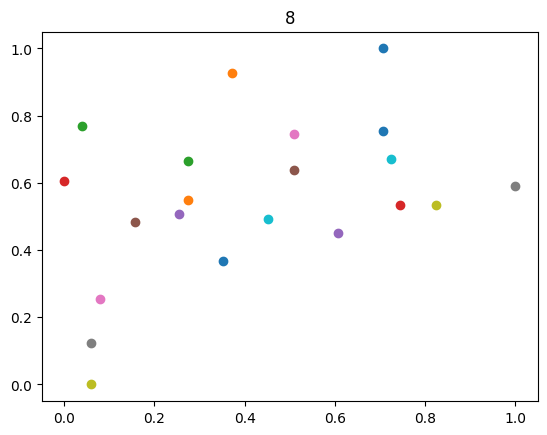

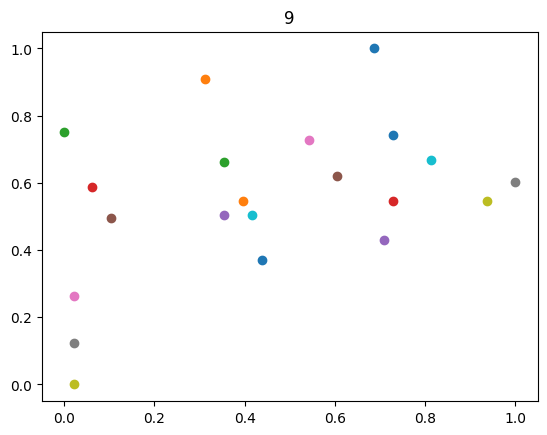

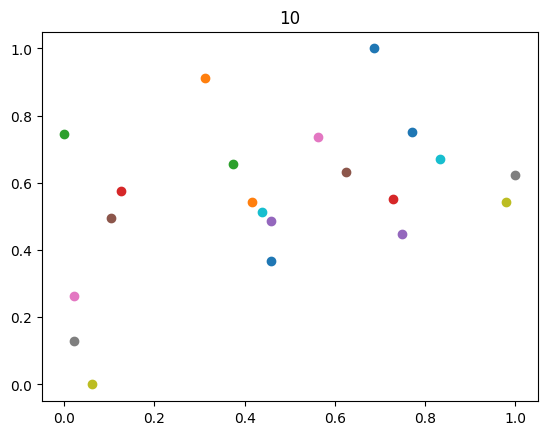

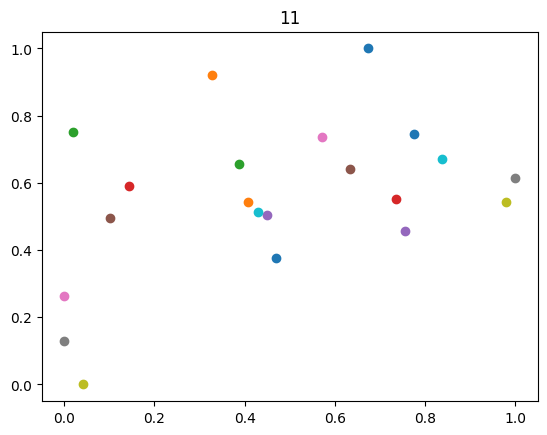

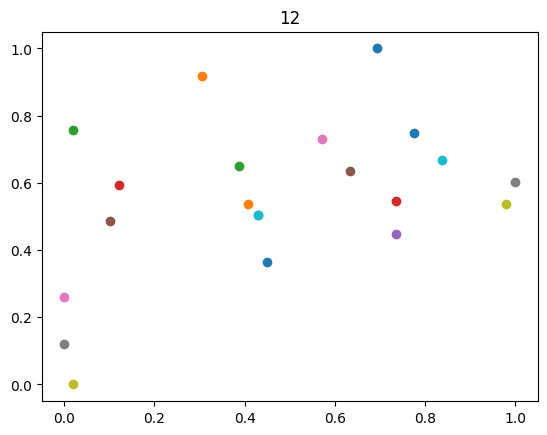

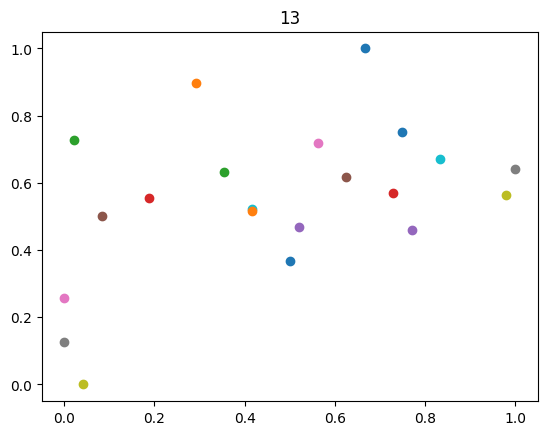

KeyboardInterrupt: 

In [24]:
data=data.drop_duplicates()    
from time import sleep
for i in range(len(data)):
 for col in cols:
     plt.scatter(data.iloc[i][col+'_x'],data.iloc[i][col+'_y'])
 plt.title(i)
 plt.show()
 sleep(1)
